## WideNet prototype

In [1]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[+] Using Keras version 2.1.4
[i] Finished Importing Modules
[i] . Reading from csv file...Done!
[i] Found 33856 unique tokens.
[+] Shape of data tensor: (45309, 30)
[+] Shape of label tensor: (45309, 5)
[+] Number of entries in each category:
[+] Training:
 [ 7708. 13062. 12739.  1861.   878.]
[+] Validation:
 [1936. 3235. 3199.  460.  231.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...Completed!
Finished running setup.


In [2]:
# second embedding matrix for non-static channel
'''embeddings_index = {}
f = open(GLOVE_DIR)
print("[i] Loading GloVe from:",GLOVE_DIR,"...",end="")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()'''
print("Done.\n[+] Proceeding with Embedding Matrix...", end="")
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Done.
[+] Proceeding with Embedding Matrix...Completed!


In [3]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [4]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [5]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',kernel_regularizer=regularizers.l2(0.001))(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [6]:

l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu')(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu')(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [7]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(5)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(24, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [8]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [9]:
!rm -r logs

In [10]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.2f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [11]:
model.summary()
model.save('BalanceNet.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6771400     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6771400     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [12]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=50,
          callbacks=[tensorboard, lr_schedule, model_checkpoints])

Training Progress:
Train on 36248 samples, validate on 9061 samples
Epoch 1/20
36248/36248 [==============================] - 237s 7ms/step - loss: 1.1367 - acc: 0.5275 - val_loss: 0.9958 - val_acc: 0.5879
Epoch 2/20
36248/36248 [==============================] - 237s 7ms/step - loss: 0.9535 - acc: 0.6113 - val_loss: 0.9382 - val_acc: 0.6180
Epoch 3/20
36248/36248 [==============================] - 241s 7ms/step - loss: 0.9345 - acc: 0.6195 - val_loss: 0.9379 - val_acc: 0.6132
Epoch 4/20
36248/36248 [==============================] - 236s 6ms/step - loss: 0.9234 - acc: 0.6229 - val_loss: 0.9304 - val_acc: 0.6207
Epoch 5/20
36248/36248 [==============================] - 234s 6ms/step - loss: 0.9122 - acc: 0.6281 - val_loss: 0.9340 - val_acc: 0.6185
Epoch 6/20
36248/36248 [==============================] - 264s 7ms/step - loss: 0.9019 - acc: 0.6302 - val_loss: 0.9271 - val_acc: 0.6207
Epoch 7/20
36248/36248 [==============================] - 258s 7ms/step - loss: 0.8958 - acc: 0.6350 - v

KeyboardInterrupt: 

In [ ]:
import pandas as pd
pd.DataFrame(model_log.history).to_csv("history-balance.csv")

In [16]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import itertools
np.set_printoptions(precision=2)
classes = ["neutral", "happy", "sad", "hate","anger"]

model_test = load_model('checkpoint.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [17]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

             precision    recall  f1-score   support

    neutral       0.50      0.34      0.41      1936
      happy       0.65      0.70      0.67      3235
        sad       0.62      0.72      0.66      3199
       hate       0.65      0.52      0.58       460
      anger       0.98      0.68      0.80       231

avg / total       0.62      0.62      0.61      9061



Normalized confusion matrix
[[3.42e-01 3.15e-01 3.28e-01 1.39e-02 1.03e-03]
 [1.10e-01 7.00e-01 1.82e-01 7.42e-03 0.00e+00]
 [8.75e-02 1.72e-01 7.20e-01 2.03e-02 6.25e-04]
 [5.43e-02 8.04e-02 3.50e-01 5.15e-01 0.00e+00]
 [2.60e-02 8.23e-02 1.73e-01 3.90e-02 6.80e-01]]


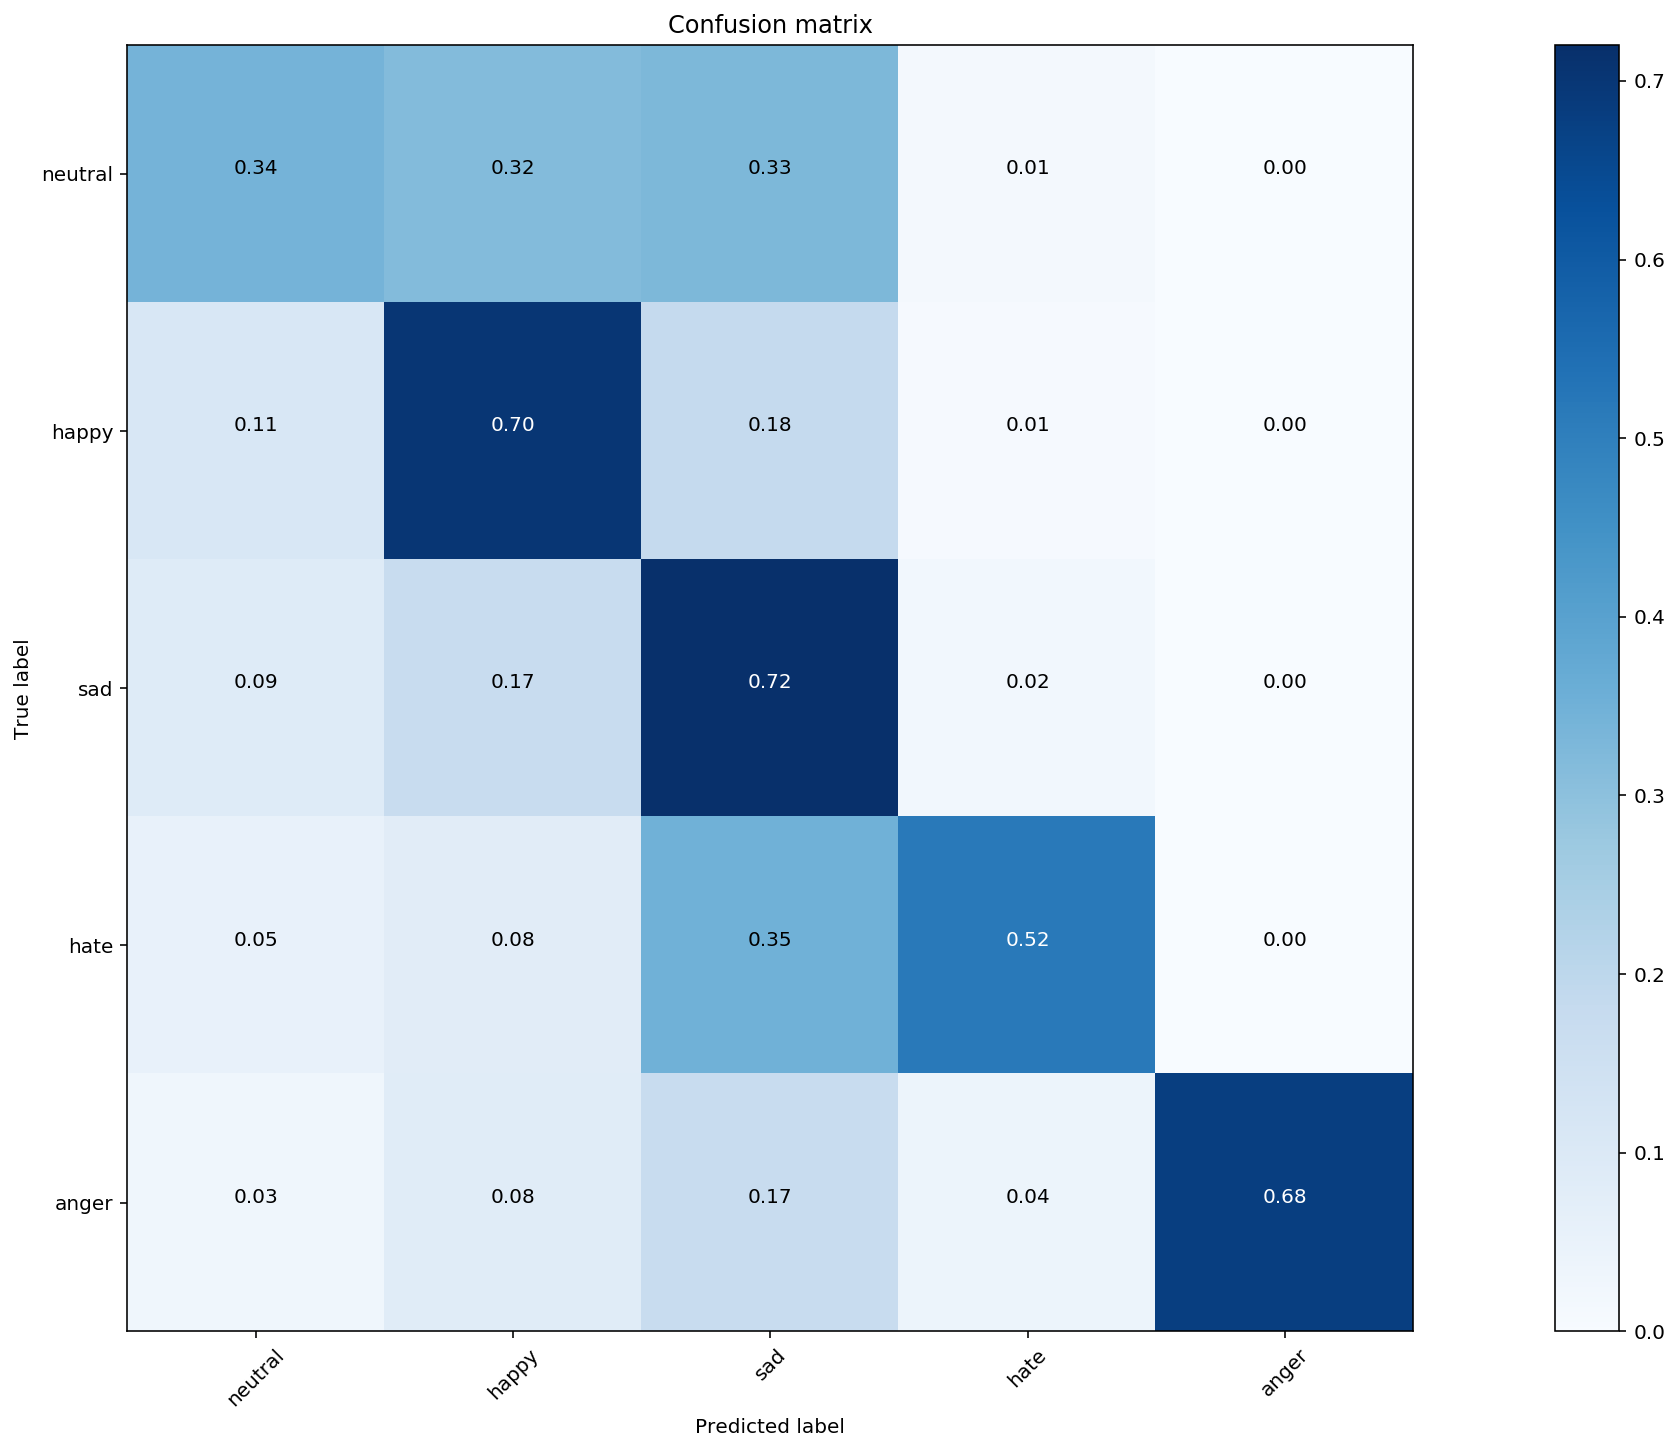

In [18]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)